In [1]:
import networkx as nx
import matplotlib.pyplot as plt
%matplotlib inline
import itertools
import numpy as np
import cvxpy as cp
from copy import deepcopy
import scipy

## Exercise 1. Consider the following network with link capacities

In [2]:
G = nx.DiGraph()
G.add_nodes_from(['o', 'a', 'b', 'c', 'd'])
G.add_edges_from([('o', 'a'), ('o', 'b'), ('a', 'b'), ('a', 'd'), ('b', 'c'), ('c', 'd')])
G['o']['a']['capacity'] = 3
G['o']['b']['capacity'] = 3
G['a']['b']['capacity'] = 1
G['a']['d']['capacity'] = 3
G['b']['c']['capacity'] = 3
G['c']['d']['capacity'] = 2

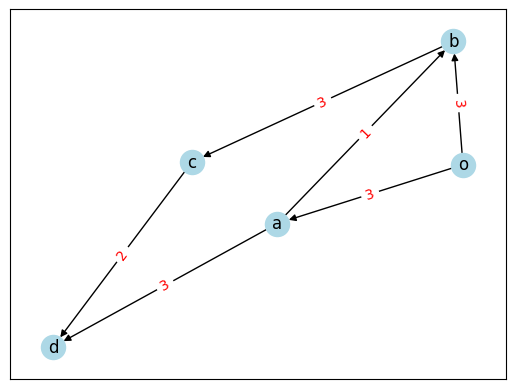

In [3]:
pos = nx.spring_layout(G)

nx.draw_networkx_nodes(G, pos, node_color ='lightblue')

nx.draw_networkx_labels(G, pos)

nx.draw_networkx_edges(G, pos, arrows=True, width=1)

nx.draw_networkx_edge_labels(G,pos,edge_labels={('o','a'):'3',('o','b'):'3',
('a','b'):'1',('a','d'):'3',('b','c'):'3',('c','d'):'2'},font_color='red')

plt.show()

### a) Compute the capacity of all the cuts and find the minimum capacity to be removed for no feasible flow from o to d to exist.

the computational cost is exponential respect to the number of nodes

In [4]:
def all_s_t_cuts(G):
    nodes = list(G.nodes())
    cuts = []
    for r in range(1, len(nodes)):
        for S in itertools.combinations(nodes, r):
            S = set(S)
            T = set(nodes) - S
            # sum capacities of edges leaving S (only edges u->v with u in S and v in T)
            cut_value = sum(G[u][v].get('capacity', 0) for u in S for v in G.successors(u) if v in T)
            cuts.append((S, T, cut_value))
    return cuts

In [5]:
all_cuts = all_s_t_cuts(G)
for S,T,val in all_cuts:
    print(f"S: {S}, T: {T}, value: {val}")

def count_min_cuts(G):
    all_cuts = all_s_t_cuts(G)
    min_cut_value = min(val for S,T,val in all_cuts)
    min_cuts = [(S,T) for S,T,val in all_cuts if val == min_cut_value]
    return len(min_cuts), min_cut_value, min_cuts

print("\nMinimum Cuts Information:")

n_min_cuts, min_cut_value, min_cuts = count_min_cuts(G)
print(f"Number of minimum cuts: {n_min_cuts}")
print(f"Minimum cut value: {min_cut_value}")
print("Minimum cuts:")
for S,T in min_cuts:
    print(f"S: {S}, T: {T}")

S: {'o'}, T: {'a', 'b', 'd', 'c'}, value: 6
S: {'a'}, T: {'b', 'o', 'd', 'c'}, value: 4
S: {'b'}, T: {'a', 'o', 'd', 'c'}, value: 3
S: {'c'}, T: {'a', 'b', 'o', 'd'}, value: 2
S: {'d'}, T: {'a', 'b', 'o', 'c'}, value: 0
S: {'a', 'o'}, T: {'b', 'd', 'c'}, value: 7
S: {'b', 'o'}, T: {'a', 'd', 'c'}, value: 6
S: {'o', 'c'}, T: {'a', 'b', 'd'}, value: 8
S: {'o', 'd'}, T: {'a', 'b', 'c'}, value: 6
S: {'a', 'b'}, T: {'o', 'd', 'c'}, value: 6
S: {'a', 'c'}, T: {'b', 'o', 'd'}, value: 6
S: {'a', 'd'}, T: {'b', 'o', 'c'}, value: 1
S: {'b', 'c'}, T: {'a', 'o', 'd'}, value: 2
S: {'b', 'd'}, T: {'a', 'o', 'c'}, value: 3
S: {'d', 'c'}, T: {'a', 'b', 'o'}, value: 0
S: {'a', 'b', 'o'}, T: {'d', 'c'}, value: 6
S: {'a', 'o', 'c'}, T: {'b', 'd'}, value: 9
S: {'a', 'o', 'd'}, T: {'b', 'c'}, value: 4
S: {'b', 'o', 'c'}, T: {'a', 'd'}, value: 5
S: {'b', 'o', 'd'}, T: {'a', 'c'}, value: 6
S: {'o', 'd', 'c'}, T: {'a', 'b'}, value: 6
S: {'a', 'b', 'c'}, T: {'o', 'd'}, value: 5
S: {'a', 'b', 'd'}, T: {'o', 'c'

as a consequence of the max-flow min-cut theorem the minimum capacity to be removed is equal to the minimum cut

In [6]:
minimum_capacity_to_be_removed, minimum_cut = nx.algorithms.flow.minimum_cut(G, 'o', 'd', capacity='capacity')
print("Minimum capacity to be removed to disconnect o from d:", minimum_capacity_to_be_removed)
print("Minimum cut sets (S, T):", minimum_cut)

Minimum capacity to be removed to disconnect o from d: 5
Minimum cut sets (S, T): ({'a', 'b', 'o', 'c'}, {'d'})


In [7]:
max_flow_value = nx.flow.maximum_flow_value(G, 'o', 'd', capacity='capacity')
print("Maximum flow value from o to d:", max_flow_value)

Maximum flow value from o to d: 5


### b) You are given x > 0 extra units of capacity (x ∈ Z). How should you distribute them in order to maximize the throughput that can be sent from o to d? Plot the maximum throughput from o to d as a function of x ≥ 0.

In [8]:
def distribute_extra_capacity(G, extra_capacity, source, target):

    H = deepcopy(G)

    while extra_capacity > 0:
        # Trova min cut e relative partizioni
        cut_value, (S, T) = nx.flow.minimum_cut(H, source, target)
        
        # Trova gli archi che attraversano il taglio
        cut_edges = [(u, v) for u in S for v in H.successors(u) if v in T]
        
        if not cut_edges:
            break  # Non ci sono più archi da potenziare
        
        # Aumenta la capacità di un arco del taglio (strategia: round robin)
        for u, v in cut_edges:
            if extra_capacity == 0:
                break
            H[u][v]['capacity'] += 1
            extra_capacity -= 1
    
    # Calcolo nuovo flusso massimo
    new_flow_value, _ = nx.flow.maximum_flow(H, source, target)
    return new_flow_value


In [9]:
def plot_max_flow_vs_extra_capacity(G, source, sink, max_extra_capacity):
    extra_capacities = list(range(max_extra_capacity + 1))
    max_flows = [distribute_extra_capacity(G, x, source, sink) for x in extra_capacities]

    print(max_flows)
    
    plt.plot(extra_capacities, max_flows, marker='o')
    plt.title('Maximum Throughput from o to d vs Extra Capacity')
    plt.xlabel('Extra Capacity Added')
    plt.ylabel('Maximum Throughput from o to d')
    plt.grid()
    plt.show()

[5, 5, 6, 7, 7, 7, 7, 8, 9, 9, 9, 9, 10, 11, 11, 12, 12, 12, 12, 13, 14, 14, 14, 14, 15, 16, 16, 17, 17, 17, 17]


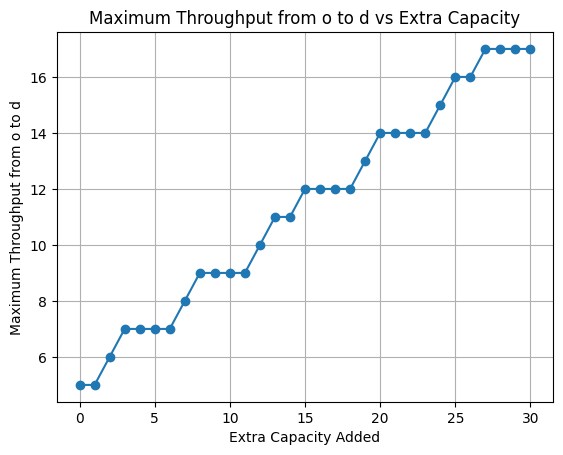

In [10]:
plot_max_flow_vs_extra_capacity(G, 'o', 'd', 30)

### c) You are given the possibility of adding to the network a directed link e8 with capacity c8 = 1 and x > 0 extra units of capacity (x ∈ Z). Where should you add the link and how should you distribute the additional capacity in order to maximize the throughput that can be sent from o to d? Plot the maximum throughput from o to d as a function of x ≥ 0.

In [11]:
def add_edge_to_maximize_flow(G, source, sink, extra_capacity):
    best_increase = 0
    best_edge = None
    original_flow_value, _ = nx.flow.maximum_flow(G, source, sink)
    
    nodes = list(G.nodes())
    for u in nodes:
        for v in nodes:
            if u != v and not G.has_edge(u, v):
                G.add_edge(u, v, capacity=1)
                new_flow_value = distribute_extra_capacity(G, extra_capacity, source, sink)  # Recalculate flow with new edge
                flow_increase = new_flow_value - original_flow_value
                if flow_increase > best_increase:
                    best_increase = flow_increase
                    best_edge = (u, v)
                G.remove_edge(u, v)
    
    return best_edge, best_increase


In [12]:
best_edge, best_increase = add_edge_to_maximize_flow(G, 'o', 'd', 3)
print("Best edge to add:", best_edge)
print("Increase in maximum flow:", best_increase)

Best edge to add: ('o', 'd')
Increase in maximum flow: 3


Extra capacity: 1, Best edge to add: ('o', 'd'), Increase in maximum flow: 1
Extra capacity: 2, Best edge to add: ('o', 'd'), Increase in maximum flow: 2
Extra capacity: 3, Best edge to add: ('o', 'd'), Increase in maximum flow: 3
Extra capacity: 4, Best edge to add: ('o', 'd'), Increase in maximum flow: 4
Extra capacity: 5, Best edge to add: ('o', 'd'), Increase in maximum flow: 5
Extra capacity: 6, Best edge to add: ('o', 'd'), Increase in maximum flow: 5
Extra capacity: 7, Best edge to add: ('o', 'd'), Increase in maximum flow: 5
Extra capacity: 8, Best edge to add: ('o', 'd'), Increase in maximum flow: 5
Extra capacity: 9, Best edge to add: ('o', 'd'), Increase in maximum flow: 6


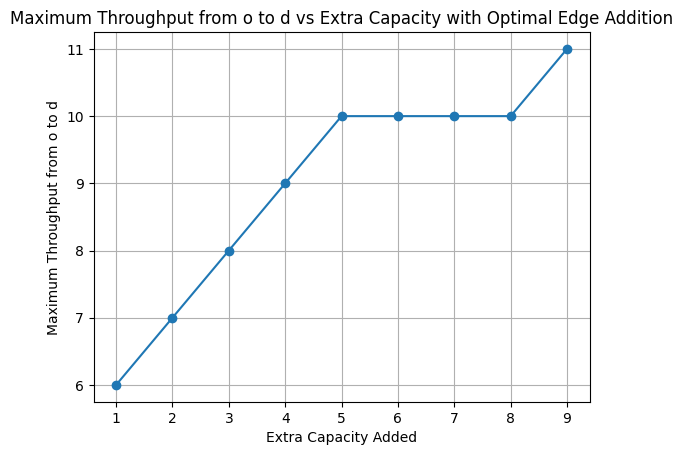

In [13]:
extra_capacities = []
max_flows = []
for extra_capacity in range(1, 10):
    best_edge, best_increase = add_edge_to_maximize_flow(G, 'o', 'd', extra_capacity)
    print(f"Extra capacity: {extra_capacity}, Best edge to add: {best_edge}, Increase in maximum flow: {best_increase}")
    G.add_edge(best_edge[0], best_edge[1], capacity=1)
    new_flow_value = distribute_extra_capacity(G, extra_capacity, 'o', 'd')
    G.remove_edge(best_edge[0], best_edge[1])
    extra_capacities.append(extra_capacity)
    max_flows.append(new_flow_value)

plt.plot(extra_capacities, max_flows, marker='o')
plt.title('Maximum Throughput from o to d vs Extra Capacity with Optimal Edge Addition')
plt.xlabel('Extra Capacity Added')
plt.ylabel('Maximum Throughput from o to d')
plt.grid()
plt.show()


## Exercise 2. Consider the following simple graph

In [14]:
SG = nx.Graph()
SG.add_nodes_from(range(1, 16))
SG.add_edges_from([(10, 9), (11, 9), (12, 9), (13, 9), (14, 9), (9, 8), (8,7), (7, 6), (15, 6),
                   (6, 5), (6, 4), (6, 3), (6, 2), (6, 1), (5, 4), (5, 3), (5, 2), (5, 1),
                   (4, 3), (4, 2), (4, 1), (3, 2), (3, 1), (2, 1)])

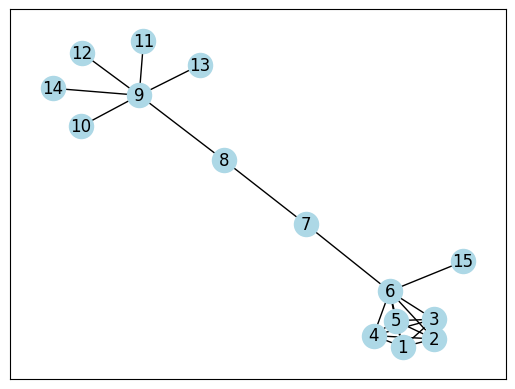

In [15]:
pos = nx.spring_layout(SG)

nx.draw_networkx_nodes(SG, pos, node_color ='lightblue')

nx.draw_networkx_labels(SG, pos)

nx.draw_networkx_edges(SG, pos, arrows=True, width=1)

plt.show()

### a) Compute the Katz centrality, with β = 0.15 and uniform intrinsic centrality µ. You can implement the computation in Matlab, Python or whatever language you prefer.

In [16]:
kc = nx.algorithms.katz_centrality(SG, beta=0.15, normalized=False)
for node, centrality in kc.items():
    print(f"Node {node}: Katz Centrality = {centrality:.4f}")

Node 1: Katz Centrality = 0.3071
Node 2: Katz Centrality = 0.3071
Node 3: Katz Centrality = 0.3071
Node 4: Katz Centrality = 0.3071
Node 5: Katz Centrality = 0.3071
Node 6: Katz Centrality = 0.3423
Node 7: Katz Centrality = 0.2038
Node 8: Katz Centrality = 0.1961
Node 9: Katz Centrality = 0.2575
Node 10: Katz Centrality = 0.1757
Node 11: Katz Centrality = 0.1757
Node 12: Katz Centrality = 0.1757
Node 13: Katz Centrality = 0.1757
Node 14: Katz Centrality = 0.1757
Node 15: Katz Centrality = 0.1842


In [17]:
N = SG.number_of_nodes()
beta = 0.15
mu = np.ones((N,1))/N

# arbitrary initial condition: 1/N-uniform vector of size N (initial condition does not matters)
z_0 = np.ones((N,1))/N

# set a tolerance to assess convergence to the limit
tol = 1e-5

# run the dynamics, initialize z
z_old = z_0

# Compute W
W = nx.adjacency_matrix(SG)
W = W.toarray()

# Compute radius
eval, evec = np.linalg.eig(W)
eval = eval.real
radius = np.max(eval)


print("Radius of matrix W:"+str(radius))

while True:
    # Define update rule of z
    z_new = W.T @ z_old * (1-beta)/radius + beta * mu
    if np.linalg.norm(z_new-z_old) < tol:
        break
    z_old=z_new

zk_distr = z_new

# normalize the centrality
zk_distr = zk_distr / sum(zk_distr)

print("Katz centrality: \n", zk_distr)

Radius of matrix W:5.071061467321912
Katz centrality: 
 [[0.11813757]
 [0.11813757]
 [0.11813757]
 [0.11813757]
 [0.11813757]
 [0.13007854]
 [0.04424685]
 [0.03172152]
 [0.04281285]
 [0.02430452]
 [0.02430452]
 [0.02430452]
 [0.02430452]
 [0.02430452]
 [0.03892977]]


### b) Write a distributed algorithm for the computation of Page-rank centrality, with β = 0.15 and uniform intrinsic centrality µ

In [18]:
def distributed_pagerank(G, beta, mu):
    # compute matrices of the graph
    W = nx.adjacency_matrix(G)
    W = W.toarray()
    degrees = np.sum(W,axis=1)
    D = np.diag(degrees)
    P = np.linalg.inv(D) @ W

    N = G.number_of_nodes() 
    # note that the normalization of mu does not influence z, if we consider normalized centralities

    # compute the largest eigenvalue of W (which is real because of Perron-Frobenius theorem)
    w,v = np.linalg.eig(W)
    w = w.real

    # arbitrary initial condition: 1/N-uniform vector of size N (initial condition does not matters)
    z_0 = np.ones((N,1))/N

    # set a tolerance to assess convergence to the limit
    tol = 1e-5

    # run the dynamics
    z_old = z_0

    while True:
        z_new = P.T @ z_old * (1-beta) + beta * mu
        if np.linalg.norm(z_new-z_old) < tol:
            break
        z_old=z_new

    zb_distr = z_new

    # normalize the centrality
    zb_distr = zb_distr / sum(zb_distr)
    return {node: zb_distr[i,0] for i, node in enumerate(SG.nodes())}

zb_dict = distributed_pagerank(SG, beta=0.15, mu=np.ones((SG.number_of_nodes(),1)))

for node, centrality in zb_dict.items():
    print(f"Node {node}: PageRank = {centrality:.4f}")

Node 1: PageRank = 0.0747
Node 2: PageRank = 0.0747
Node 3: PageRank = 0.0747
Node 4: PageRank = 0.0747
Node 5: PageRank = 0.0747
Node 6: PageRank = 0.1145
Node 7: PageRank = 0.0486
Node 8: PageRank = 0.0581
Node 9: PageRank = 0.1940
Node 10: PageRank = 0.0375
Node 11: PageRank = 0.0375
Node 12: PageRank = 0.0375
Node 13: PageRank = 0.0375
Node 14: PageRank = 0.0375
Node 15: PageRank = 0.0239


In [19]:
prc = nx.link_analysis.pagerank(SG)
for node, pagerank in prc.items():
    print(f"Node {node}: PageRank = {pagerank:.4f}")

Node 1: PageRank = 0.0747
Node 2: PageRank = 0.0747
Node 3: PageRank = 0.0747
Node 4: PageRank = 0.0747
Node 5: PageRank = 0.0747
Node 6: PageRank = 0.1145
Node 7: PageRank = 0.0486
Node 8: PageRank = 0.0581
Node 9: PageRank = 0.1940
Node 10: PageRank = 0.0375
Node 11: PageRank = 0.0375
Node 12: PageRank = 0.0375
Node 13: PageRank = 0.0375
Node 14: PageRank = 0.0375
Node 15: PageRank = 0.0239


In [20]:
distributed_pagerank(SG, beta=0, mu=np.ones((SG.number_of_nodes(),1)))

{1: np.float64(0.10416662748744476),
 2: np.float64(0.10416662748744476),
 3: np.float64(0.10416662748744476),
 4: np.float64(0.10416662748744476),
 5: np.float64(0.10416662748744476),
 6: np.float64(0.14583372611986656),
 7: np.float64(0.04166606799228966),
 8: np.float64(0.04166772570996612),
 9: np.float64(0.12499564707852784),
 10: np.float64(0.020834084441354064),
 11: np.float64(0.020834084441354064),
 12: np.float64(0.020834084441354064),
 13: np.float64(0.020834084441354064),
 14: np.float64(0.020834084441354064),
 15: np.float64(0.020833273455355374)}

### d)

0.12697769964544145


Text(0.5, 0, 'Beta')

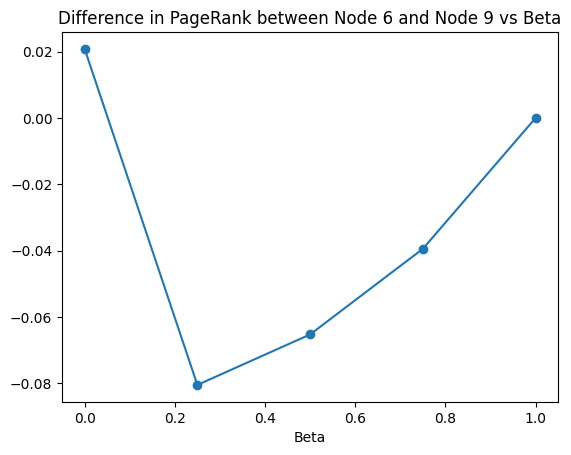

In [21]:
pr_res = [distributed_pagerank(SG, beta, mu=np.ones((SG.number_of_nodes(),1))) for beta in [0, 0.25, 0.5, 0.75, 1]]
f = [res.get(6) - res.get(9) for res in pr_res]
print(pr_res[3].get(9))
plt.plot([0, 0.25, 0.5, 0.75, 1], f, marker='o')
plt.title('Difference in PageRank between Node 6 and Node 9 vs Beta')
plt.xlabel('Beta')

## Exercise 3

In [22]:
f = scipy.io.loadmat('flow.mat')["flow"].reshape(28,)
C = scipy.io.loadmat('capacities.mat')["capacities"].reshape(28,)
B = scipy.io.loadmat('traffic.mat')["traffic"]
l = scipy.io.loadmat('traveltime.mat')["traveltime"].reshape(28,)

In [23]:
HG = nx.DiGraph()

num_nodes, num_edges = B.shape

# aggiungiamo nodi
HG.add_nodes_from(range(num_nodes))

# ricaviamo archi e capacità
for j in range(num_edges):
    src = np.where(B[:, j] == 1)[0][0]
    dst = np.where(B[:, j] == -1)[0][0]
    HG.add_edge(src, dst, capacity=int(C[j]), travel_time=l[j])

In [24]:
def check_non_negative_edges(G):
    for u, v, data in G.edges(data=True):
        if G[u][v]['travel_time'] < 0:
            return False
    return True

In [25]:
check_non_negative_edges(HG)

True

In [26]:
#nx.draw(HG)

### a) Find the shortest path between node 1 and 17. This is equivalent to the fastest path (path with shortest traveling time) in an empty network.

In [27]:
sp = nx.algorithms.shortest_path(HG, source=0, target=16, weight='travel_time')
path = ""
for node in sp:
    path += str(node + 1) + " " + "-> "
print(path)
total_travel_time = sum(HG[sp[i]][sp[i+1]]['travel_time'] for i in range(len(sp)-1))
print("Total travel time along the shortest path:", total_travel_time)

1 -> 2 -> 3 -> 9 -> 13 -> 17 -> 
Total travel time along the shortest path: 0.559833


### b) Find the maximum flow between node 1 and 17.

In [28]:
mf = nx.flow.maximum_flow(HG, 0, 16, capacity='capacity')
print("Maximum flow value from node 1 to node 17:", mf[0])

Maximum flow value from node 1 to node 17: 22448


### c) Given the flow vector in flow.mat, compute the vector $ν$ satisfying $Bf = ν$

In [29]:
nu = B @ f
print("Vector ν satisfying Bf = ν:", nu)

Vector ν satisfying Bf = ν: [ 16806   8570  19448   4957   -746   4768    413     -2  -5671   1169
     -5  -7131   -380  -7412  -7810  -3430 -23544]


In [30]:
nu.sum() == 0

np.True_

### d) Find the social optimum $f^∗$ with respect to the delays on the different links $τ_e(f_e)$. For this, minimize the cost function $$\sum_{e \in \mathcal E}f_e \tau_e (f(e)) = \sum_{e \in \mathcal E} \frac {f_e l_e}{1 - f_e / c_e} = \sum_{e \in \mathcal E}(\frac {l_ec_e}{1-f_e/c_e}-l_ec_e)$$ subject to the flow constraints

In [31]:
def compute_total_delay(f, func='regular'):
    """
    Computes the total delay based on the given flow `f`.
    :param f: Flow vector.
    :param func: Specifies the type of delay computation.
    :return: Total delay.
    """
    if func == 'regular':
        return np.sum(l * C / (1 - f / C) - l * C)
    elif func == 'new':
        return np.sum(l * C / (1 - f / C) - l * C + f * C)

In [32]:
n_edges = B.shape[1]
nu_source = nu[0]
nu_sink = -nu_source
nu = np.zeros(B.shape[0])
nu[0] = nu_source
nu[-1] = nu_sink
f_opt = cp.Variable(n_edges)
# use right cost expression to respect DCP rules
num = l * C
#den = 1 - f_opt / C
den = 1 - cp.multiply(f_opt, cp.inv_pos(C))
inv_den  = cp.inv_pos(den)
term1 = cp.multiply(num, inv_den)
cost = term1 - num
#print("cost function is convex?", cp.sum(cost).is_convex())
objective = cp.Minimize(cp.sum(cost))
#objective = cp.Minimize(cp.sum(cp.multiply(l * C, cp.inv_pos(1 - f_opt / C)) - l * C))
constraints = [B @ f_opt == nu, f_opt >=0, f_opt <= C]
prob = cp.Problem(objective, constraints)
result = prob.solve()
print("Optimal flow values on edges:", f_opt.value)

Optimal flow values on edges: [6.56934343e+03 5.81000870e+03 3.04697202e+03 3.04697044e+03
 1.02366566e+04 4.66633524e+03 3.06121109e+03 2.59598535e+03
 3.10455509e+03 7.59334729e+02 5.72744560e-03 2.76303096e+03
 1.57821332e-03 3.04697044e+03 5.57032133e+03 2.89383855e+03
 5.04094165e+03 2.36445888e+03 4.65231471e+02 2.25446280e+03
 3.35906803e+03 5.61353083e+03 2.37198823e+03 1.99673781e-03
 6.34609768e+03 5.41895867e+03 5.04094365e+03 5.04094365e+03]


In [33]:
prob.solver_stats.solver_name

'CLARABEL'

In [34]:
total_delay = compute_total_delay(f_opt.value, func='regular')
print("Total delay with optimal flow:", total_delay, result)

Total delay with optimal flow: 26142.669749995475 26142.669749995475


### e) Find the Wardrop equilibrium $f^{(0)}$. For this, use the cost function $$\psi_e(f_e) = \sum_{e \in \mathcal E} \int_{0}^{f_e} \tau_e(s)ds = -\sum_{e \in \mathcal E} l_ec_e \text{ln}(1 - \frac {f_e}{c_e})$$

In [35]:
f_w = cp.Variable(n_edges)
objective_w = cp.sum(cp.multiply(-l * C, cp.log(1 - cp.multiply(f_w, cp.inv_pos(C)))))
constraints_w = [B @ f_w == nu, f_w >=0, f_w <= C]
prob_w = cp.Problem(cp.Minimize(objective_w), constraints_w)
f_w_opt = prob_w.solve()
print("Wardrop equilibrium:", f_w.value)

Wardrop equilibrium: [6.55750561e+03 6.30859527e+03 2.20072140e+03 2.20072138e+03
 1.02484944e+04 4.70669121e+03 2.85981287e+03 2.23263877e+03
 3.34992731e+03 2.48910340e+02 1.16462355e+01 4.09622764e+03
 1.44395841e-05 2.20072138e+03 5.54180318e+03 2.34344230e+03
 5.29414955e+03 2.09578867e+03 6.38820341e+02 2.97893911e+03
 2.98226262e+03 5.96120173e+03 2.52236088e+03 2.24569380e-05
 6.78876816e+03 4.72308226e+03 5.29414957e+03 5.29414957e+03]


In [36]:
total_delay_we = compute_total_delay(f_w.value)
print("Total delay at Wardrop equilibrium:", total_delay_we, f_w_opt)

Total delay at Wardrop equilibrium: 26495.287958196597 15731.952643030687


In [37]:
total_delay_we / total_delay

np.float64(1.013488224866597)

### f) Introduce tolls $$\frac{df_e}{​dτ_e}​​=\frac{l_e}{c_e​(1−f_e​/c_e​)^2}​​$$

In [38]:
f_toll = cp.Variable(n_edges)
den_toll = cp.multiply(C, cp.power(1 - f_opt.value / C, 2)) # c * (1 - f / C)^2
inv_den_toll = cp.inv_pos(den_toll)
delay_der = cp.multiply(l, inv_den_toll)
toll = cp.multiply(f_opt.value, delay_der)
log_term_toll = cp.log(1 - f_toll / C)
objective_toll = cp.sum(cp.multiply(-l *C, log_term_toll))
constraints_toll = [B @ f_toll == nu, f_toll >=0, f_toll <= C]
prob_toll = cp.Problem(cp.Minimize(objective_toll + toll.T @ f_toll), constraints_toll)
res_toll = prob_toll.solve()
print("Wardrop equilibrium with tolls:", f_toll.value)

Wardrop equilibrium with tolls: [6.56815120e+03 5.80995135e+03 3.04697769e+03 3.04697768e+03
 1.02378488e+04 4.66745753e+03 3.06125944e+03 2.59585166e+03
 3.10451734e+03 7.58199850e+02 3.92407823e-05 2.76297362e+03
 1.43200202e-05 3.04697768e+03 5.57039127e+03 2.89380129e+03
 5.04098792e+03 2.36439794e+03 4.65407815e+02 2.25430795e+03
 3.35920908e+03 5.61351703e+03 2.37195384e+03 2.11646894e-05
 6.34608053e+03 5.41893152e+03 5.04098794e+03 5.04098794e+03]


In [39]:
#check if wardrop equilibrium with tolls is equal with optimum flow (lab 3)
f_opt.value - f_toll.value

array([ 1.19223368,  0.05735491, -0.0056752 , -0.0072391 , -1.19222669,
       -1.1222843 , -0.04834243,  0.13368997,  0.03774927,  1.13487877,
        0.0056882 ,  0.05734191,  0.00156389, -0.0072391 , -0.06994238,
        0.03726615, -0.04627164,  0.06093689, -0.17634419,  0.1548465 ,
       -0.14105362,  0.01379288,  0.03438926,  0.00197557,  0.01715289,
        0.02715016, -0.04429606, -0.04429606])

In [40]:
total_delay_tolls = compute_total_delay(f_toll.value)
print("Total delay with tolls at optimal flow:", total_delay_tolls)

Total delay with tolls at optimal flow: 26142.67135556477


In [41]:
total_delay_tolls / total_delay

np.float64(1.0000000614156592)

### g) Instead of the total travel time, let the cost for the system be the total additional travel time compared to the total travel time in free flow, given by $$ψ_e(f_e) = f_e(τ_e(f_e) − l_e)$$ subject to the flow constraints. Compute the system optimum $f^∗$ for the costs above. Construct a toll vector $ω^∗$ such that the Wardrop equilibrium $f(ω^∗)$ coincides with $f^∗$. Compute the new Wardrop equilibrium with the constructed tolls $f(ω^∗)$ to verify your result.

In [42]:
f_opt_new = cp.Variable(f.shape)

# ψ_e(f_e) = f_e*τ_e(f_e) - f_e*l_e) -> (f_e*τ_e(f_e) see point d)
objective = cp.Minimize(cp.sum(cp.multiply(l * C, cp.inv_pos(1 - f_opt_new / C)) - l * C - cp.multiply(f_opt_new, l)))
constraints = [
    B @ f_opt_new == nu,  # Flow conservation: net flow at each node must equal supply/demand
    f_opt_new >= 0,       # Non-negativity constraint: flow on any edge cannot be negative
    f_opt_new <= C        # Capacity constraint: flow cannot exceed the edge capacity
]
prob = cp.Problem(objective, constraints)
result = prob.solve()

print('Optimal f:', f_opt_new.value)

total_delay_f_opt_new = compute_total_delay(f_opt_new.value, 'new')
print('Total delay for f^*:', total_delay_f_opt_new)

w_var = cp.Variable(l.shape)
objective = cp.Minimize(cp.sum(
    -cp.multiply(l * C, cp.log(1 - cp.multiply(f_opt_new.value, cp.inv_pos(C))))
    - f_opt_new.value * l + cp.multiply(f_opt_new.value, w_var)
))
constraints = [w_var >= 0]  # Tolls must be non-negative
prob = cp.Problem(objective, constraints)
result = prob.solve()
print('Optimal w*:', w_var.value)

f_toll_new = cp.Variable(f.shape)
objective = cp.Minimize(cp.sum(
    -cp.multiply(l * C, cp.log(1 - f_toll_new / C)) - cp.multiply(f_toll_new, l) + cp.multiply(f_toll_new, w_var.value)
))
constraints = [
    B @ f_toll_new == nu,  # Flow conservation
    f_toll_new >= 0,       # Non-negativity constraint
    f_toll_new <= C        # Capacity constraint
]
prob = cp.Problem(objective, constraints)
result = prob.solve()

print('Optimal f with w*:', f_toll_new.value)

total_delay_f_w_tolls_new = compute_total_delay(f_toll_new.value, 'new')
print('Total delay for f^(w*):', total_delay_f_w_tolls_new)

Optimal f: [6.58451091e+03 5.57770824e+03 3.36756475e+03 3.36755932e+03
 1.02214891e+04 4.66944310e+03 3.15651862e+03 2.71195152e+03
 2.98789183e+03 1.00680267e+03 3.72678946e-03 2.21013977e+03
 5.42668359e-03 3.36755932e+03 5.55204599e+03 3.08485436e+03
 4.98691878e+03 2.51972715e+03 4.44570825e+02 1.93420488e+03
 3.52942308e+03 5.46362796e+03 2.20221142e+03 2.10795648e-03
 6.24930837e+03 5.56977074e+03 4.98692089e+03 4.98692089e+03]
Total delay for f^*: 1003960473.4412076
Optimal w*: [-5.34529672e-13 -5.00978601e-13 -2.07203724e-13 -2.07202083e-13
 -5.56386686e-13 -4.38147365e-13 -1.36281338e-13  7.47331816e-14
 -6.76889604e-14  4.45345329e-12  1.71578363e-06  4.84624316e-13
  1.15037076e-06 -2.07202083e-13 -4.99742143e-13 -1.08578571e-13
 -4.65307609e-13  2.03393044e-13  1.59979382e-11  8.51631123e-13
 -2.52540855e-13 -4.95291644e-13  4.93373125e-13  3.60150502e-06
 -5.26071134e-13 -5.00598738e-13 -4.65307767e-13 -4.65307767e-13]
Optimal f with w*: [6.67053526e+03 5.71570972e+03 3.2

In [43]:
total_delay_f_w_tolls_new / total_delay_f_opt_new

np.float64(1.0002089210961964)